# Bài tập về nhà Decision Tree, Random Forest


- Thực hiện các yêu cầu dưới đây với tập dữ liệu Australian credit
- Down dữ liệu tại đường link dưới đây và đặt vào folder /data
 
  https://archive.ics.uci.edu/ml/datasets/Statlog+(Australian+Credit+Approval)
    

In [3]:
# import packages,...

# set random_state = 0


## 1. Tìm hiểu dữ liệu

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 


In [29]:
'''
- Tìm hiểu cấu trúc data tại trang web UCI
- Down các files, đặt trong folder data/
- Chú ý:
    - Đọc mô tả dữ liệu trong file 'australian.doc'
    - Kiểm tra DecisionTree/RandomForest của Sklearn có hỗ trợ với kiểu dữ liệu được cung cấp không
'''
data_path = 'data/australian.dat'

credit = np.genfromtxt(data_path)
credit = pd.DataFrame(data = credit)

credit.columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','Y']
print(credit[:5])

X = credit.iloc[:, :-1]
y = credit.iloc[:, -1]
print("\n This is X before one-hot encoding \n:", X)

encode_rules = ColumnTransformer(
    transformers=[('one_hot_encoder', OneHotEncoder(categories='auto'), [3,4,5,11])],
    remainder='passthrough'
)
X = encode_rules.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


print("shape of labels: ", y_train.shape)



    X1     X2     X3   X4   X5   X6     X7   X8   X9   X10  X11  X12    X13  \
0  1.0  22.08  11.46  2.0  4.0  4.0  1.585  0.0  0.0   0.0  1.0  2.0  100.0   
1  0.0  22.67   7.00  2.0  8.0  4.0  0.165  0.0  0.0   0.0  0.0  2.0  160.0   
2  0.0  29.58   1.75  1.0  4.0  4.0  1.250  0.0  0.0   0.0  1.0  2.0  280.0   
3  0.0  21.67  11.50  1.0  5.0  3.0  0.000  1.0  1.0  11.0  1.0  2.0    0.0   
4  1.0  20.17   8.17  2.0  6.0  4.0  1.960  1.0  1.0  14.0  0.0  2.0   60.0   

      X14    Y  
0  1213.0  0.0  
1     1.0  0.0  
2     1.0  0.0  
3     1.0  1.0  
4   159.0  1.0  

 This is X before one-hot encoding 
:       X1     X2      X3   X4    X5   X6     X7   X8   X9   X10  X11  X12  \
0    1.0  22.08  11.460  2.0   4.0  4.0  1.585  0.0  0.0   0.0  1.0  2.0   
1    0.0  22.67   7.000  2.0   8.0  4.0  0.165  0.0  0.0   0.0  0.0  2.0   
2    0.0  29.58   1.750  1.0   4.0  4.0  1.250  0.0  0.0   0.0  1.0  2.0   
3    0.0  21.67  11.500  1.0   5.0  3.0  0.000  1.0  1.0  11.0  1.0  2.0   
4   

## 2. Decision Tree

### 2.1. Khảo sát các giá trị khác nhau của max_depth

Text(0.5, 1.0, 'Survey for max_depth')

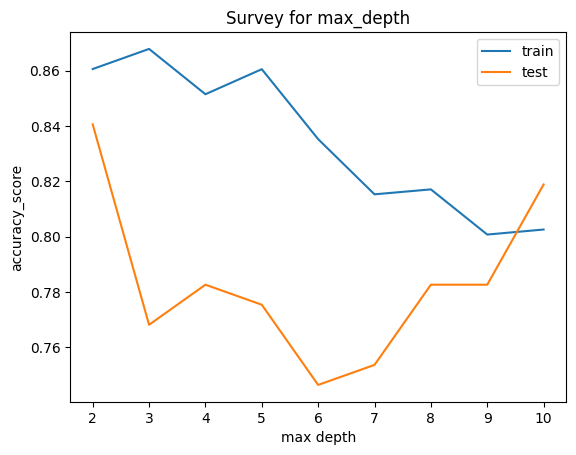

In [37]:
# code
max_depth_values = np.arange(2, 11)
accuracies_score_by_depth = []
test_accuracies_score_by_depth =[]
for current_max_depth in max_depth_values:
    model = DecisionTreeClassifier (max_depth= current_max_depth)

    val_scores = cross_val_score(estimator= model, X= x_train, y = y_train, cv = 5, scoring='accuracy')
    accuracies_score_by_depth.append(val_scores.mean())

    model.fit(x_train, y_train)
    curr_prediction = model.predict(x_test)
    test_accuracies_score_by_depth.append(accuracy_score(curr_prediction, y_test))



# Visualization
plt.plot(max_depth_values, accuracies_score_by_depth, label = "train")
plt.plot(max_depth_values, test_accuracies_score_by_depth, label = 'test')
plt.xlabel('max depth')
plt.ylabel('accuracy_score')
plt.legend()
plt.title("Survey for max_depth")


### 2.2. Tìm kiếm siêu tham số

In [41]:
#code
parameter = {
    'max_depth': [2, 3, 4, 5, 6, 7],
    'min_samples_split': np.arange(2, 102, 20),
    'min_samples_leaf': np.arange(1, 201, 20),
    'max_leaf_nodes': [2, 5, 10, 12, 18],
    'class_weight': ['balanced', None]

}
grid = GridSearchCV(DecisionTreeClassifier(), parameter, verbose=1, n_jobs = -1)
grid = grid.fit(x_train, y_train)
print("###################################\n")
print(grid.best_params_)
y_pred = grid.predict(x_test)
print(accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 3000 candidates, totalling 15000 fits
###################################

{'class_weight': None, 'max_depth': 5, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.7753623188405797


## 3. Random Forest

### 3.1 Khảo sát các giá trị khác nhau của n_estimators

Text(0, 0.5, 'Scores')

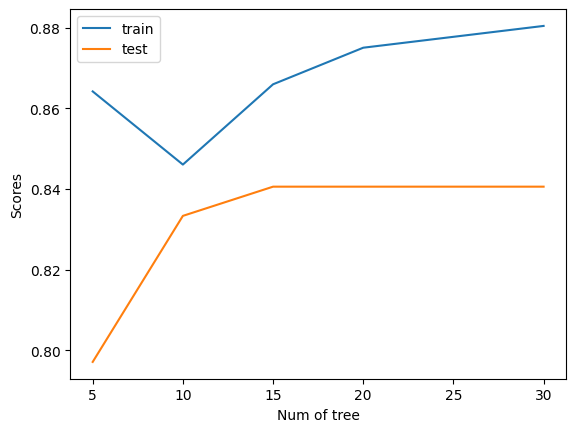

In [50]:
#code
num_trees = [5, 10, 15, 20, 30]
train_acc = []
test_acc = []

for current_num_tree in num_trees:
    model = RandomForestClassifier(n_estimators = current_num_tree, n_jobs = -1)
    model.fit(x_train, y_train)
    curr_train_accuracy = cross_val_score(model, x_train, y_train, cv = 5, scoring= "accuracy")
    train_acc.append(curr_train_accuracy.mean())

    cur_test_accuracy = accuracy_score(y_test, model.predict(x_test))
    test_acc.append(cur_test_accuracy)


plt.plot(num_trees, train_acc, label = "train")
plt.plot(num_trees, test_acc, label = "test")

plt.legend()
plt.xlabel("Num of tree")
plt.ylabel("Scores")

### 3.2 Tìm kiếm siêu tham số

In [52]:
# code
parameter = {
    'max_depth': np.arange(1, 30),
    'min_samples_leaf': np.arange(1, 30),
    'n_estimators': np.arange(1, 50)
}
grid = GridSearchCV(RandomForestClassifier(), param_grid= parameter, n_jobs=-1, verbose=1 )
grid = grid.fit(x_train, y_train)
print("###################################\n")
print(grid.best_params_)
y_pred = grid.predict(x_test)
print(accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 41209 candidates, totalling 206045 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will requi